<a href="https://colab.research.google.com/github/dimasandhikaaa/BIG-DATA-DATA-MINING/blob/main/UAS_BDDM_22_11_5352_Klasifikasi_Batu_Ginjal_Berdasarkan_Urine_Analysis_Menggunakan_Machine_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Importing libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
import warnings
from sklearn import set_config

# General settings
set_config(display="diagram")
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

## Exploratory Data Analysis

In [ ]:
df = pd.read_csv('/kindey stone urine analysis.csv')

df.head()

,gravity,ph,osmo,cond,urea,calc,target
0,1.021,4.91,725,14.0,443,2.45,0
1,1.017,5.74,577,20.0,296,4.49,0
2,1.008,7.20,321,14.9,101,2.36,0
3,1.011,5.51,408,12.6,224,2.15,0
4,1.005,6.52,187,7.5,91,1.16,0


In [ ]:
# Checking for missing values
df.isna().values.sum()

0

In [ ]:
df.describe()

,gravity,ph,osmo,cond,urea,calc,target
count,79.000000,79.000000,79.000000,79.000000,79.000000,79.000000,79.000000
mean,1.018114,6.028481,612.848101,20.813924,266.405063,4.138987,0.430380
std,0.007239,0.724307,237.514755,7.938994,131.254550,3.260051,0.498293
min,1.005000,4.760000,187.000000,5.100000,10.000000,0.170000,0.000000
25%,1.012000,5.530000,413.000000,14.150000,160.000000,1.460000,0.000000
50%,1.018000,5.940000,594.000000,21.400000,260.000000,3.160000,0.000000
75%,1.023500,6.385000,792.000000,26.550000,372.000000,5.930000,1.000000
max,1.040000,7.940000,1236.000000,38.000000,620.000000,14.340000,1.000000


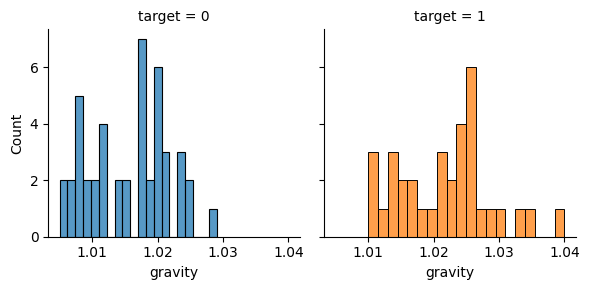

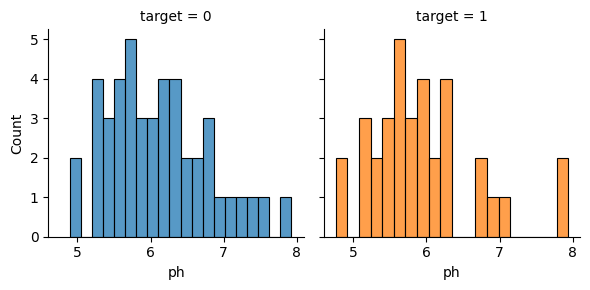

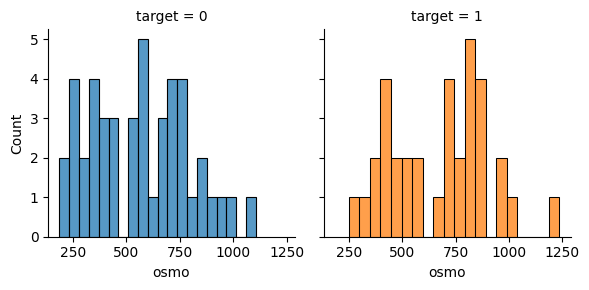

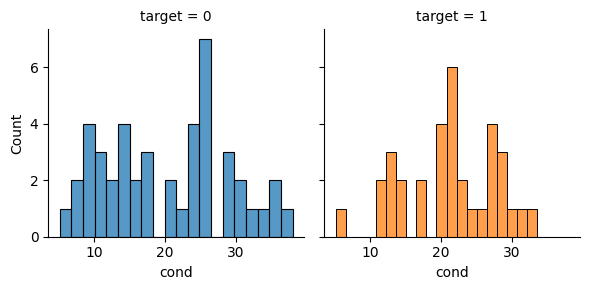

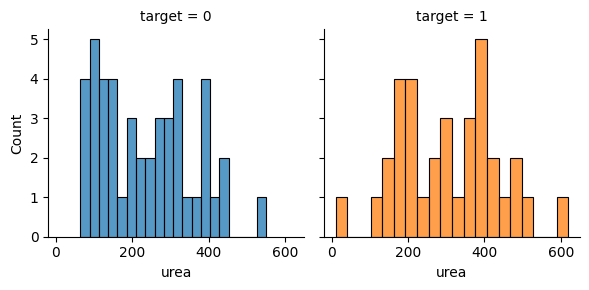

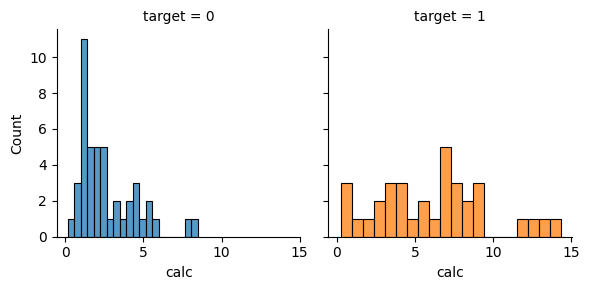

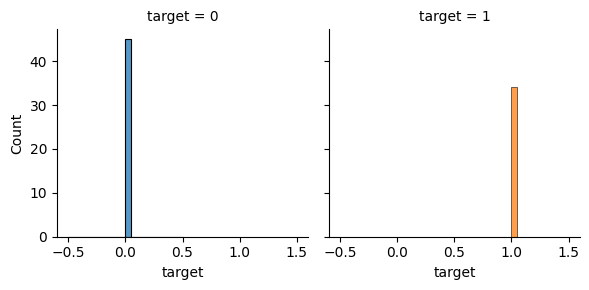

In [ ]:
for col in df.columns:
    g = sns.FacetGrid(data = df, col = 'target', hue = 'target')
    g.map(sns.histplot, col, bins = 20)
plt.show()

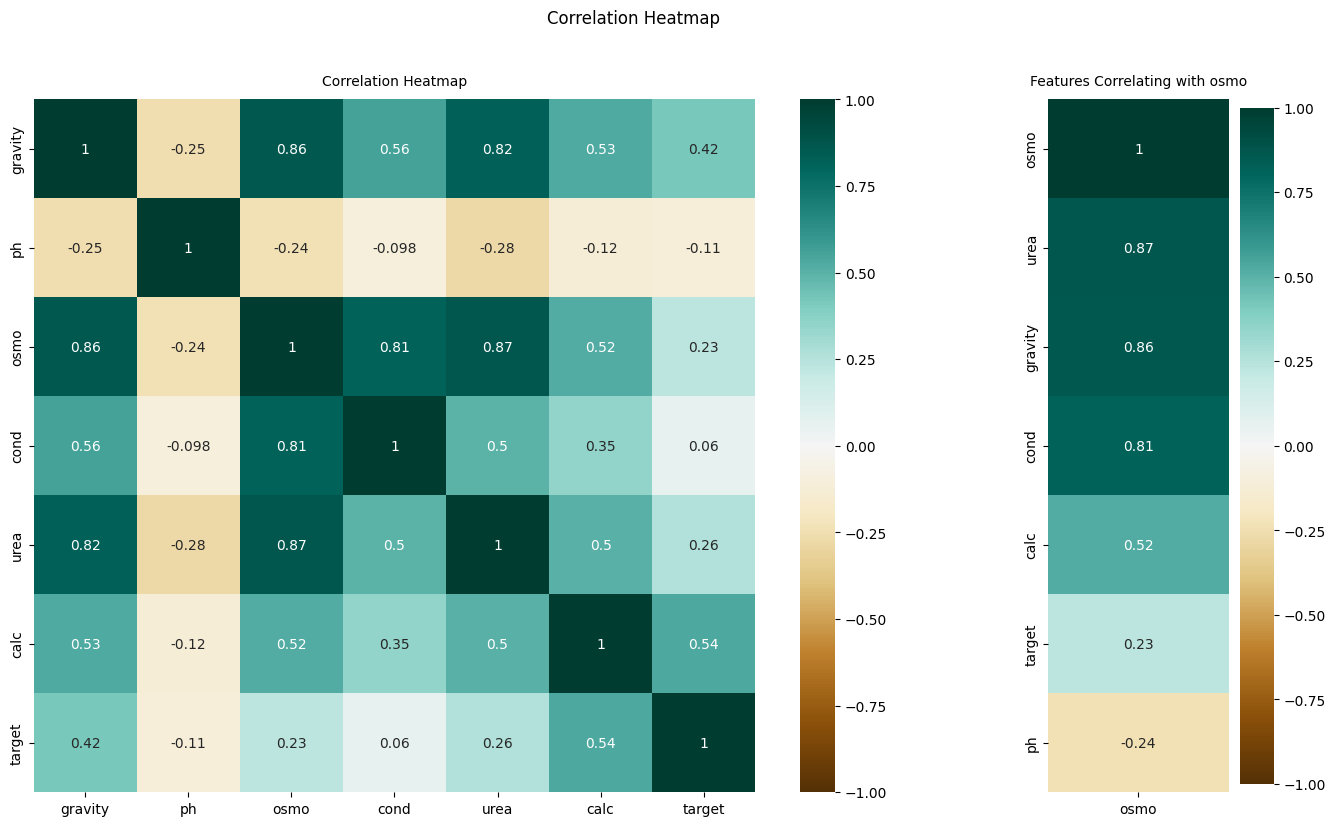

In [ ]:
fig, axes = plt.subplots(1, 2, sharey = False, figsize = (16, 9), gridspec_kw = {"width_ratios" : [4, 1]})
fig.suptitle('Correlation Heatmap')

sns.heatmap(ax = axes[0],
            data = df.corr(),
            vmin = -1, vmax = 1,
            annot = True,
            cmap = 'BrBG')
axes[0].set_title('Correlation Heatmap', fontdict = {'fontsize' : 10}, pad = 10)

sns.heatmap(ax = axes[1],
            data = df.corr()[['osmo']].sort_values(by = 'osmo', ascending = False),
            vmin = -1, vmax = 1,
            annot = True,
            cmap = 'BrBG')
axes[1].set_title('Features Correlating with osmo', fontdict = {'fontsize' : 10}, pad = 10)
plt.show()

## Data Pre-processing

In [ ]:
# Define X, y and create pre-processing pipeline
X = df.drop(columns = ['target'])
y = df['target']

preprocessor = Pipeline(steps = [
    ('polynom', PolynomialFeatures(degree = 2)),
    ('scaler', StandardScaler())
])

# Implement class Model() that would do 5-fold cross validation on the classifier of choice
class Model():
    def __init__(self, preprocessor, model_instance, X, y):
        self.X = X
        self.y = y
        self.preprocessor = preprocessor
        self.model = model_instance

    def Validation_Scores(self):
        model = Pipeline(steps = [
            ('preprocessor', self.preprocessor),
            ('classifier', self.model)
        ])
        cv_scores = cross_validate(model, self.X, self.y, cv = 5, n_jobs = -1,
                                   scoring = ('accuracy', 'f1', 'precision', 'recall', 'roc_auc'))
        cv_scores = pd.DataFrame(cv_scores)
        return cv_scores.mean(axis = 0)

## Model

In [ ]:
classifier = LogisticRegression()
LRC = Model(preprocessor, classifier, X, y)
result_LRC = LRC.Validation_Scores()
result_LRC.name = 'Logistic Regression'
result_LRC

,Logistic Regression
fit_time,0.015362
score_time,0.023102
test_accuracy,0.748333
test_f1,0.682351
test_precision,0.730952
test_recall,0.652381
test_roc_auc,0.823810


In [ ]:
classifier = SVC()
SVC = Model(preprocessor, classifier, X, y)
result_SVM = SVC.Validation_Scores()
result_SVM.name = 'Support Vector Machine'
result_SVM

,Support Vector Machine
fit_time,0.007682
score_time,0.020733
test_accuracy,0.735833
test_f1,0.625455
test_precision,0.780000
test_recall,0.538095
test_roc_auc,0.788889


In [ ]:
results = pd.concat([result_LRC, result_SVM], axis = 1)
results = results.transpose().drop(columns = ['score_time', 'fit_time'])
results

,test_accuracy,test_f1,test_precision,test_recall,test_roc_auc
Logistic Regression,0.748333,0.682351,0.730952,0.652381,0.823810
Support Vector Machine,0.735833,0.625455,0.780000,0.538095,0.788889


In [ ]:
# Define the parameter grids for hyperparameter tuning
param_grid_lr = {
    'classifier__C': [0.1, 1, 10],
    'classifier__penalty': ['l1', 'l2'],
    'preprocessor__polynom__degree': [1, 2]
}

param_grid_svc = {
    'classifier__C': [0.1, 1, 10],
    'classifier__kernel': ['linear', 'rbf'],
    'preprocessor__polynom__degree': [1, 2]
}


def hyperparameter_tuning(model, param_grid):
    pipeline = Pipeline(steps=[
        ('preprocessor', Pipeline([('polynom', PolynomialFeatures()), ('scaler', StandardScaler())])),
        ('classifier', model)
    ])

    grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X, y)

    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best cross-validation score: {grid_search.best_score_}")
    return grid_search.best_estimator_


# Logistic Regression hyperparameter tuning
best_lr_model = hyperparameter_tuning(LogisticRegression(), param_grid_lr)

# Support Vector Machine hyperparameter tuning
best_svc_model = hyperparameter_tuning(SVC(), param_grid_svc)

# Evaluate best models (optional, you can add further evaluation metrics here)
# Example using cross_validate with the best models found:
def evaluate_model(model):
    cv_scores = cross_validate(model, X, y, cv=5, scoring=['accuracy', 'f1', 'precision', 'recall', 'roc_auc'], n_jobs=-1)
    cv_scores_df = pd.DataFrame(cv_scores)
    return cv_scores_df.mean()

print("\nLogistic Regression Best Model Evaluation:")
print(evaluate_model(best_lr_model))
print("\nSupport Vector Machine Best Model Evaluation:")
print(evaluate_model(best_svc_model))

Best parameters: {'classifier__C': 1, 'classifier__penalty': 'l2', 'preprocessor__polynom__degree': 1}
Best cross-validation score: 0.7733333333333333
Best parameters: {'classifier__C': 0.1, 'classifier__kernel': 'linear', 'preprocessor__polynom__degree': 2}
Best cross-validation score: 0.7858333333333334

Logistic Regression Best Model Evaluation:
fit_time          0.024970
score_time        0.070975
test_accuracy     0.773333
test_f1           0.713120
test_precision    0.764286
test_recall       0.680952
test_roc_auc      0.839683
dtype: float64

Support Vector Machine Best Model Evaluation:
fit_time          0.019363
score_time        0.057697
test_accuracy     0.785833
test_f1           0.699814
test_precision    0.833333
test_recall       0.623810
test_roc_auc      0.846561
dtype: float64


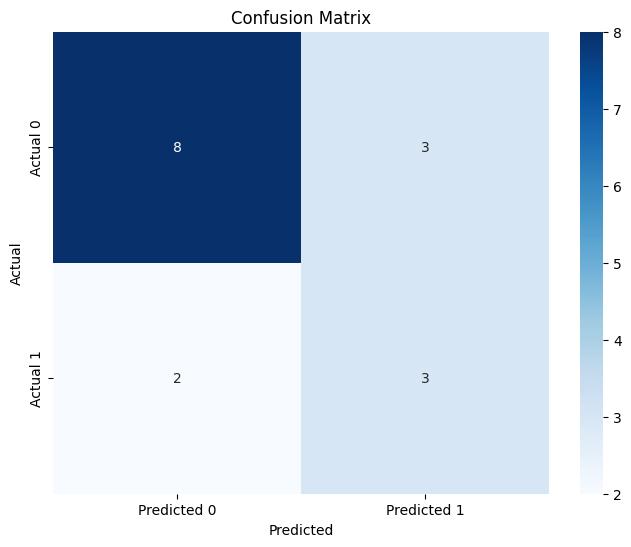

In [ ]:
from sklearn.metrics import confusion_matrix

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

classifier = LogisticRegression()
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', classifier)
])

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()